# IBD Study

In [1]:
import re
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy.stats as stats
import torch
import biom
import matplotlib_venn
from metvae.model import MetVAE

import matplotlib.pyplot as plt
%matplotlib inline

## Data Import

In [2]:
abundance_data = pd.read_csv('../data/ibd/ibd_abundance.csv', index_col=0)
fmd = pd.read_csv('../data/ibd/ibd_fmd.csv', index_col=0)
smd = pd.read_csv('../data/ibd/ibd_smd.csv', index_col=0)

print('Abundance data shape: ', abundance_data.shape)
print('Feature metadata shape: ', fmd.shape)
print('Sample metadata shape: ', smd.shape)

Abundance data shape:  (479, 70)
Feature metadata shape:  (479, 7)
Sample metadata shape:  (70, 489)


### Outcomes of interest

In [3]:
smd['diagnosis'].value_counts()

diagnosis
CD        31
UC        20
nonIBD    19
Name: count, dtype: int64

### Covariates/confounders

In [4]:
smd.rename(columns={'Antibiotics': 'abx'}, inplace=True)
smd['abx'].value_counts()

abx
No     61
Yes     9
Name: count, dtype: int64

In [5]:
smd['sex'].value_counts()

sex
Female    41
Male      29
Name: count, dtype: int64

In [6]:
smd.rename(columns={'consent_age': 'age'}, inplace=True)
smd[['age']].describe()

,age
count,70.000000
mean,30.428571
std,18.692455
min,6.000000
25%,14.250000
50%,27.000000
75%,43.750000
max,76.000000


## Exploratory Analysis

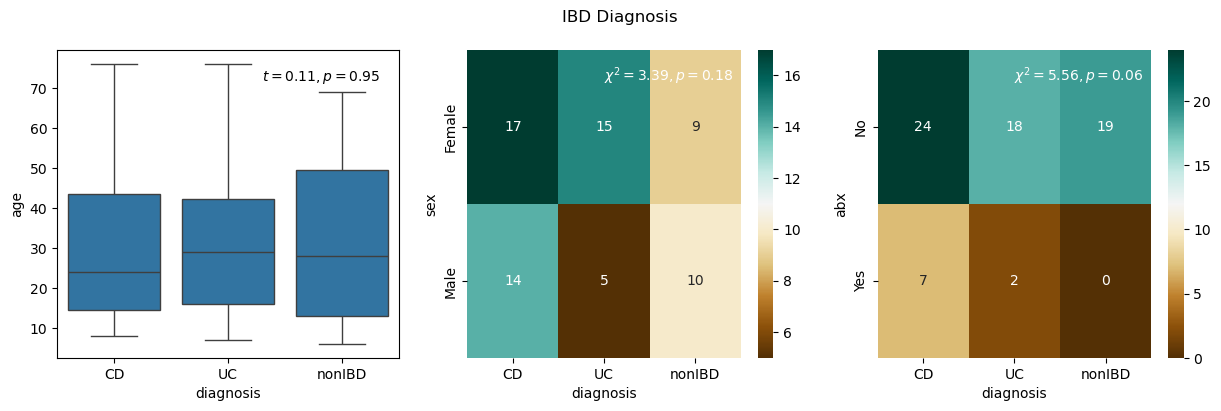

In [7]:
fig, axs = plt.subplots(1, 3, figsize = (15, 4))
fig.suptitle('IBD Diagnosis')

fig1 = sns.boxplot(x = 'diagnosis', y = 'age', data = smd, ax = axs[0])
t, p = stats.kruskal(smd.loc[smd['diagnosis'] == 'CD', 'age'],
                     smd.loc[smd['diagnosis'] == 'UC', 'age'],
                     smd.loc[smd['diagnosis'] == 'nonIBD', 'age'])
plt.text(0.6, 0.9, f'$t = {t:.2f}, p = {p:.2f}$', transform = axs[0].transAxes)

crosstab = pd.crosstab(smd['sex'], smd['diagnosis'])
fig2 = sns.heatmap(crosstab, annot = True, fmt='d', cmap = 'BrBG', ax = axs[1])
t, p, _, _ = stats.chi2_contingency(crosstab)
plt.text(0.5, 0.9, f'$\\chi^2 = {t:.2f}, p = {p:.2f}$', color = 'white', transform = axs[1].transAxes)

crosstab = pd.crosstab(smd['abx'], smd['diagnosis'])
fig3 = sns.heatmap(crosstab, annot = True, fmt='d', cmap = 'BrBG', ax = axs[2])
t, p, _, _ = stats.chi2_contingency(crosstab)
plt.text(0.5, 0.9, f'$\\chi^2 = {t:.2f}, p = {p:.2f}$', color = 'white', transform = axs[2].transAxes)

plt.show()

## Run MetVAE

### Data pre-processing

In [8]:
# CD cases
smd_cd = smd[smd['diagnosis'] == 'CD']
data_cd = abundance_data[smd_cd.index].T
# Calculate the proportion of zeros in each column
proportion_zeros = (data_cd == 0).mean()
data_cd = data_cd.loc[:, proportion_zeros <= 0.5]
n, d = data_cd.shape

print('# CD cases:', n)
print('# metabolites:', d)
print('Proportion of zeros: ', np.round((data_cd == 0).sum().sum()/data_cd.size*100), '%')

# CD cases: 31
# metabolites: 457
Proportion of zeros:  5.0 %


In [9]:
# UC cases
smd_uc = smd[smd['diagnosis'] == 'UC']
data_uc = abundance_data[smd_uc.index].T
# Calculate the proportion of zeros in each column
proportion_zeros = (data_uc == 0).mean()
data_uc = data_uc.loc[:, proportion_zeros <= 0.5]
n, d = data_uc.shape

print('# UC cases:', n)
print('# metabolites:', d)
print('Proportion of zeros: ', np.round((data_uc == 0).sum().sum()/data_uc.size*100), '%')

# UC cases: 20
# metabolites: 459
Proportion of zeros:  5.0 %


In [10]:
# Non-IBD controls
smd_ctrl = smd[smd['diagnosis'] == 'nonIBD']
data_ctrl = abundance_data[smd_ctrl.index].T
# Calculate the proportion of zeros in each column
proportion_zeros = (data_ctrl == 0).mean()
data_ctrl = data_ctrl.loc[:, proportion_zeros <= 0.5]
n, d = data_ctrl.shape

print('# Non-IBD controls:', n)
print('# metabolites:', d)
print('Proportion of zeros: ', np.round((data_ctrl == 0).sum().sum()/data_ctrl.size*100), '%')

# Non-IBD controls: 19
# metabolites: 447
Proportion of zeros:  5.0 %


In [11]:
# Subset to the overlapped features
overlap_features = list(set(data_cd.columns).intersection(data_uc.columns).intersection(data_ctrl.columns))
overlap_features.sort()
data_cd = data_cd.loc[:, overlap_features]
data_uc = data_uc.loc[:, overlap_features]
data_ctrl = data_ctrl.loc[:, overlap_features]

print('After preprocessing:')
print('# CD cases:', data_cd.shape[0])
print('# UC cases:', data_uc.shape[0])
print('# Non-IBD controls:', data_ctrl.shape[0])
print('# metabolites:', len(overlap_features))
print('Proportion of zeros in CD cases: ', np.round((data_cd == 0).sum().sum()/data_cd.size*100), '%')
print('Proportion of zeros in UC cases: ', np.round((data_uc == 0).sum().sum()/data_uc.size*100), '%')
print('Proportion of zeros in non-IBD controls: ', np.round((data_ctrl == 0).sum().sum()/data_ctrl.size*100), '%')

After preprocessing:
# CD cases: 31
# UC cases: 20
# Non-IBD controls: 19
# metabolites: 439
Proportion of zeros in CD cases:  4.0 %
Proportion of zeros in UC cases:  3.0 %
Proportion of zeros in non-IBD controls:  4.0 %


In [12]:
fmd.loc[overlap_features, 'HMDB'].isna().value_counts(dropna=False)

HMDB
False    422
True      17
Name: count, dtype: int64

### CD cases

In [13]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1000
learning_rate=1e-2

model = MetVAE(data=data_cd,
               features_as_rows=False,
               meta=smd_cd,
               continuous_covariate_keys=['age'],
               categorical_covariate_keys=['sex', 'abx'],
               latent_dim = data_cd.shape[0],
               use_gpu=False)

model.train(batch_size=100,
            num_workers=0,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            log_every_n_steps=1)

100%|██████████| 1000/1000 [00:09<00:00, 105.06it/s]


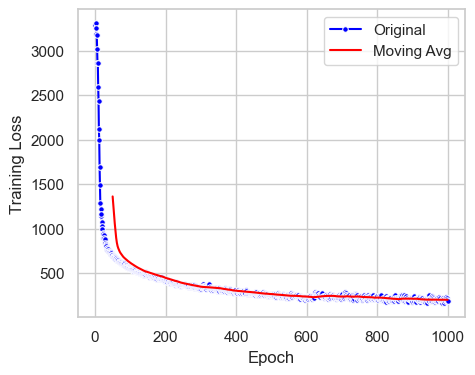

In [14]:
df_loss = pd.DataFrame({
    'Epoch': range(1, max_epochs+1),
    'Training Loss': model.train_loss
})
window_size = 50
df_loss['MA Training Loss'] = df_loss['Training Loss'].rolling(window=window_size).mean()
df_loss.replace([np.inf, -np.inf], np.nan, inplace=True)

plt.figure(figsize=(5, 4))
sns.set_theme(style="whitegrid")   
sns.lineplot(data=df_loss, x='Epoch', y='Training Loss', marker='o', markersize=4, color='blue', label='Original')
sns.lineplot(data=df_loss, x='Epoch', y='MA Training Loss', color='red', label='Moving Avg')
plt.show()

In [15]:
model.get_corr(num_sim=1000)
random.seed(123)
results_metvae = model.sparse_by_thresholding(th_len=100, n_cv=5, soft=False, n_jobs=1)
est_cor_cd = results_metvae['sparse_estimate']

df_cor_cd = pd.DataFrame(
    est_cor_cd,
    index=data_cd.columns,
    columns=data_cd.columns
)
df_cor_cd.head()

,C18n_QI06,C18n_QI07,C18n_QI08,C18n_QI10,C18n_QI11,C18n_QI12,C18n_QI13,C18n_QI14,C18n_QI15,C18n_QI16,...,HILp_TF52,HILp_TF53,HILp_TF54,HILp_TF55,HILp_TF56,HILp_TF57,HILp_TF58,HILp_TF7,HILp_TF8,HILp_TF9
C18n_QI06,1.000000,0.833631,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C18n_QI07,0.833631,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C18n_QI08,0.000000,0.000000,1.0,0.0,0.0,0.0,0.607178,0.0,0.0,0.635901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
C18n_QI10,0.000000,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.606111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.610778,0.0
C18n_QI11,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### UC cases

In [16]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1000
learning_rate=1e-2

model = MetVAE(data=data_uc,
               features_as_rows=False,
               meta=smd_uc,
               continuous_covariate_keys=['age'],
               categorical_covariate_keys=['sex', 'abx'],
               latent_dim = data_uc.shape[0],
               use_gpu=False)

model.train(batch_size=100,
            num_workers=0,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            log_every_n_steps=1)

100%|██████████| 1000/1000 [00:09<00:00, 106.38it/s]


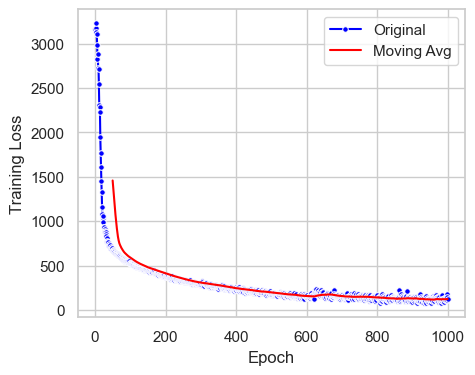

In [17]:
df_loss = pd.DataFrame({
    'Epoch': range(1, max_epochs+1),
    'Training Loss': model.train_loss
})
window_size = 50
df_loss['MA Training Loss'] = df_loss['Training Loss'].rolling(window=window_size).mean()
df_loss.replace([np.inf, -np.inf], np.nan, inplace=True)

plt.figure(figsize=(5, 4))
sns.set_theme(style="whitegrid")   
sns.lineplot(data=df_loss, x='Epoch', y='Training Loss', marker='o', markersize=4, color='blue', label='Original')
sns.lineplot(data=df_loss, x='Epoch', y='MA Training Loss', color='red', label='Moving Avg')
plt.show()

In [18]:
model.get_corr(num_sim=1000)
random.seed(123)
results_metvae = model.sparse_by_thresholding(th_len=100, n_cv=5, soft=False, n_jobs=1)
est_cor_uc = results_metvae['sparse_estimate']

df_cor_uc = pd.DataFrame(
    est_cor_uc,
    index=data_uc.columns,
    columns=data_uc.columns
)
df_cor_uc.head()

,C18n_QI06,C18n_QI07,C18n_QI08,C18n_QI10,C18n_QI11,C18n_QI12,C18n_QI13,C18n_QI14,C18n_QI15,C18n_QI16,...,HILp_TF52,HILp_TF53,HILp_TF54,HILp_TF55,HILp_TF56,HILp_TF57,HILp_TF58,HILp_TF7,HILp_TF8,HILp_TF9
C18n_QI06,1.000000,0.851942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C18n_QI07,0.851942,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C18n_QI08,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C18n_QI10,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C18n_QI11,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Non-IBD controls

In [19]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1000
learning_rate=1e-2

model = MetVAE(data=data_ctrl,
               features_as_rows=False,
               meta=smd_ctrl,
               continuous_covariate_keys=['age'],
               categorical_covariate_keys=['sex', 'abx'],
               latent_dim = data_ctrl.shape[0],
               use_gpu=False)

model.train(batch_size=100,
            num_workers=0,
            max_epochs=max_epochs,
            learning_rate=learning_rate,
            log_every_n_steps=1)

100%|██████████| 1000/1000 [00:09<00:00, 105.75it/s]


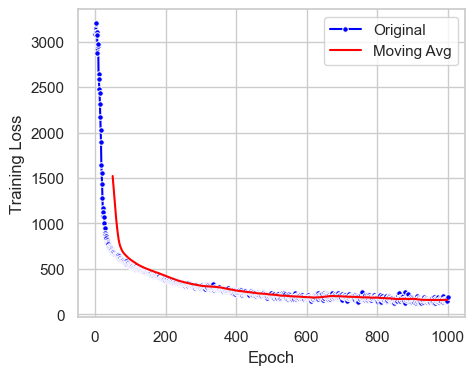

In [20]:
df_loss = pd.DataFrame({
    'Epoch': range(1, max_epochs+1),
    'Training Loss': model.train_loss
})
window_size = 50
df_loss['MA Training Loss'] = df_loss['Training Loss'].rolling(window=window_size).mean()
df_loss.replace([np.inf, -np.inf], np.nan, inplace=True)

plt.figure(figsize=(5, 4))
sns.set_theme(style="whitegrid")   
sns.lineplot(data=df_loss, x='Epoch', y='Training Loss', marker='o', markersize=4, color='blue', label='Original')
sns.lineplot(data=df_loss, x='Epoch', y='MA Training Loss', color='red', label='Moving Avg')
plt.show()

In [21]:
model.get_corr(num_sim=1000)
random.seed(123)
results_metvae = model.sparse_by_thresholding(th_len=100, n_cv=5, soft=False, n_jobs=1)
est_cor_ctrl = results_metvae['sparse_estimate']

df_cor_ctrl = pd.DataFrame(
    est_cor_ctrl,
    index=data_ctrl.columns,
    columns=data_ctrl.columns
)
df_cor_ctrl.head()

,C18n_QI06,C18n_QI07,C18n_QI08,C18n_QI10,C18n_QI11,C18n_QI12,C18n_QI13,C18n_QI14,C18n_QI15,C18n_QI16,...,HILp_TF52,HILp_TF53,HILp_TF54,HILp_TF55,HILp_TF56,HILp_TF57,HILp_TF58,HILp_TF7,HILp_TF8,HILp_TF9
C18n_QI06,1.000000,0.882082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C18n_QI07,0.882082,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C18n_QI08,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C18n_QI10,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C18n_QI11,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualizations

In [22]:
# Function to add rectangles for clusters
def add_cluster_rectangles(ax, cluster_indices, color, linewidth=2):
    """Add rectangles to highlight clusters."""
    start = min(cluster_indices)
    end = max(cluster_indices) + 1  # Include the last index
    ax.add_patch(
        plt.Rectangle(
            (start - 0.5, start - 0.5),  # Bottom-left corner
            end - start,                # Width
            end - start,                # Height
            edgecolor=color,
            fill=False,
            lw=linewidth,
            clip_on=False
        )
    )

In [23]:
# Start and end indices for the first cluster
start_idx = overlap_features.index("C8p_QI15")
end_idx = overlap_features.index("C8p_QI209") + 1  # Include the end element in the slice
cluster1 = overlap_features[start_idx:end_idx]

# Start and end indices for the second cluster
start_idx = overlap_features.index("C8p_QI21")
end_idx = overlap_features.index("C8p_QI43") + 1  # Include the end element in the slice
cluster2 = overlap_features[start_idx:end_idx]

# Start and end indices for the third cluster
start_idx = overlap_features.index("C8p_QI63")
end_idx = overlap_features.index("C8p_QI86") + 1  # Include the end element in the slice
cluster3 = overlap_features[start_idx:end_idx]

# Combine all candidates into a single list
cluster_all = cluster1 + cluster2 + cluster3

fmd.loc[cluster_all, ['HMDB', 'Method']].to_csv('../results/intermediate_results/ibd/ibd_cluster_hmdb.csv')

#### Heatmap

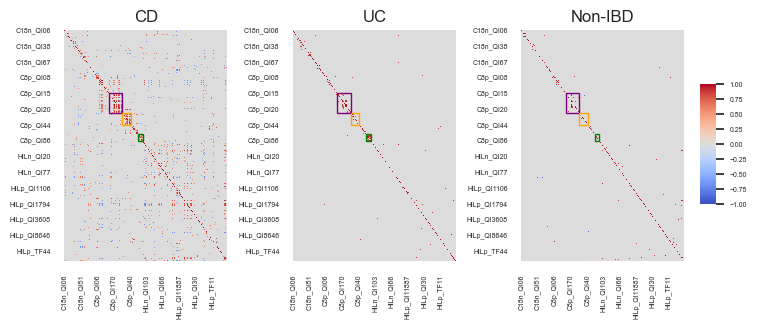

In [24]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.4})

# Create a shared color bar axis
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cbar_ax.tick_params(labelsize=5)

# Plot heatmaps and add rectangles for clusters
for ax, data, title in zip(axs, [df_cor_cd, df_cor_uc, df_cor_ctrl], ['CD', 'UC', 'Non-IBD']):
    sns.heatmap(data, cmap='coolwarm', cbar=ax == axs[0], vmin=-1, vmax=1, ax=ax, cbar_ax=cbar_ax if ax == axs[0] else None)
    ax.set_title(title)

    # Add rectangles for each cluster
    cluster1_indices = [overlap_features.index(feat) for feat in cluster1]
    cluster2_indices = [overlap_features.index(feat) for feat in cluster2]
    cluster3_indices = [overlap_features.index(feat) for feat in cluster3]

    add_cluster_rectangles(ax, cluster1_indices, 'purple', 1)
    add_cluster_rectangles(ax, cluster2_indices, 'orange', 1)
    add_cluster_rectangles(ax, cluster3_indices, 'green', 1)

    ax.tick_params(axis='both', which='major', labelsize=5)

plt.savefig('../results/figures/supp_ibd_heat.pdf', bbox_inches='tight')
plt.show()

#### Zoom-in view of the metabolites of interest

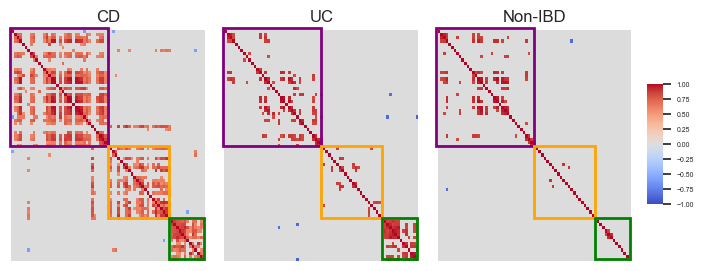

In [25]:
# Subset correlation matrices to metabolites of interest
df_cor_cd_subset = df_cor_cd.loc[cluster_all, cluster_all]
df_cor_uc_subset = df_cor_uc.loc[cluster_all, cluster_all]
df_cor_ctrl_subset = df_cor_ctrl.loc[cluster_all, cluster_all]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.1})

# Create a shared color bar axis
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cbar_ax.tick_params(labelsize=5)

# Plot heatmaps and add rectangles for clusters
for ax, data, title in zip(axs, [df_cor_cd_subset, df_cor_uc_subset, df_cor_ctrl_subset], ['CD', 'UC', 'Non-IBD']):
    sns.heatmap(data, cmap='coolwarm', cbar=ax == axs[0], vmin=-1, vmax=1, ax=ax, cbar_ax=cbar_ax if ax == axs[0] else None)
    ax.set_title(title)

    # Add rectangles for each cluster
    cluster1_indices = [cluster_all.index(feat) for feat in cluster1]
    cluster2_indices = [cluster_all.index(feat) for feat in cluster2]
    cluster3_indices = [cluster_all.index(feat) for feat in cluster3]

    add_cluster_rectangles(ax, cluster1_indices, 'purple')
    add_cluster_rectangles(ax, cluster2_indices, 'orange')
    add_cluster_rectangles(ax, cluster3_indices, 'green')

    # Remove ticks and labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='x', bottom=False)
    ax.tick_params(axis='y', left=False)

plt.savefig('../results/figures/main_ibd_heat.pdf', bbox_inches='tight')
plt.show()

#### Venn diagram

In [26]:
def extract_lower_triangle(corr_matrix):
    rows, cols = np.tril_indices(corr_matrix.shape[0], -1)
    df = pd.DataFrame({
        'feature1': corr_matrix.index[rows],
        'feature2': corr_matrix.columns[cols],
        'value': corr_matrix.values[rows, cols]
    })
    return df

df_cor_cd_long = extract_lower_triangle(df_cor_cd)
df_cor_uc_long = extract_lower_triangle(df_cor_uc)
df_cor_ctrl_long = extract_lower_triangle(df_cor_ctrl)

In [27]:
df_cor_cd_long = df_cor_cd_long.rename(columns={'value': 'value_cd'})
df_cor_uc_long = df_cor_uc_long.rename(columns={'value': 'value_uc'})
df_cor_ctrl_long = df_cor_ctrl_long.rename(columns={'value': 'value_ctrl'})

merge_df = pd.merge(df_cor_cd_long, df_cor_uc_long, on=['feature1', 'feature2'])
merge_df = pd.merge(merge_df, df_cor_ctrl_long, on=['feature1', 'feature2'])

In [28]:
# Positive correlations
df_cor_cd_pos = df_cor_cd_long[df_cor_cd_long['value_cd'] > 0]
df_cor_uc_pos = df_cor_uc_long[df_cor_uc_long['value_uc'] > 0]
df_cor_ctrl_pos = df_cor_ctrl_long[df_cor_ctrl_long['value_ctrl'] > 0]

set_cd_pos = set(zip(df_cor_cd_pos['feature1'], df_cor_cd_pos['feature2']))
set_uc_pos = set(zip(df_cor_uc_pos['feature1'], df_cor_uc_pos['feature2']))
set_ctrl_pos = set(zip(df_cor_ctrl_pos['feature1'], df_cor_ctrl_pos['feature2']))

In [29]:
# Negative correlations
df_cor_cd_neg = df_cor_cd_long[df_cor_cd_long['value_cd'] < 0]
df_cor_uc_neg = df_cor_uc_long[df_cor_uc_long['value_uc'] < 0]
df_cor_ctrl_neg = df_cor_ctrl_long[df_cor_ctrl_long['value_ctrl'] < 0]

set_cd_neg = set(zip(df_cor_cd_neg['feature1'], df_cor_cd_neg['feature2']))
set_uc_neg = set(zip(df_cor_uc_neg['feature1'], df_cor_uc_neg['feature2']))
set_ctrl_neg = set(zip(df_cor_ctrl_neg['feature1'], df_cor_ctrl_neg['feature2']))

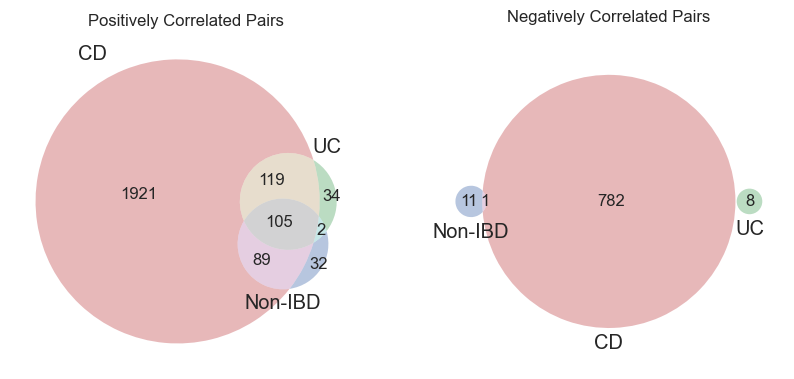

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

matplotlib_venn.venn3([set_cd_pos, set_uc_pos, set_ctrl_pos], ('CD', 'UC', 'Non-IBD'), ax=axs[0])
axs[0].set_title("Positively Correlated Pairs")

matplotlib_venn.venn3([set_cd_neg, set_uc_neg, set_ctrl_neg], ('CD', 'UC', 'Non-IBD'), ax=axs[1])
axs[1].set_title("Negatively Correlated Pairs", pad=22)

plt.savefig('../results/figures/ext_ibd_venn.pdf', bbox_inches='tight')
plt.show()

## Other Methods

### CLR transformation

In [31]:
def clr_transform(data):
    """
    Perform CLR (Centered Log-Ratio) transformation on a DataFrame.
    """
    log_data = np.log(data)  # Log transformation
    row_means = log_data.mean(axis=1)  # Row-wise means
    clr_data = log_data.subtract(row_means, axis=0)  # Subtract row means
    return clr_data

In [32]:
# Add a pseudo-count of 1 to zeros
data_cd1 = data_cd
data_uc1 = data_uc
data_ctrl1 = data_ctrl
data_cd1[data_cd1 == 0] = 1
data_uc1[data_uc1 == 0] = 1
data_ctrl1[data_ctrl1 == 0] = 1

# CLR transformation
clr_cd = clr_transform(data_cd1)
clr_uc = clr_transform(data_uc1)
clr_ctrl = clr_transform(data_ctrl1)

### Pearson's correlation

In [33]:
def calculate_pearson_correlation(data, threshold=0.005):
    d = data.shape[1]
    corr_matrix = np.zeros((d, d))
    p_matrix = np.zeros((d, d))
    
    # Compute correlations and p-values for each pair
    for i in range(d):
        for j in range(d):
            if i == j:
                corr_matrix[i, j] = 1.0  # Diagonal correlations are 1
                p_matrix[i, j] = 0.0    # Diagonal p-values are 0
            elif i < j:
                corr, p_value = stats.pearsonr(data.iloc[:, i], data.iloc[:, j])
                corr_matrix[i, j] = corr
                p_matrix[i, j] = p_value
                corr_matrix[j, i] = corr
                p_matrix[j, i] = p_value
    
    # Zero out correlations with p-values >= threshold
    corr_matrix[p_matrix >= threshold] = 0
    
    return corr_matrix

In [34]:
pearson_corr_cd = calculate_pearson_correlation(clr_cd)
pearson_corr_uc = calculate_pearson_correlation(clr_uc)
pearson_corr_ctrl = calculate_pearson_correlation(clr_ctrl)

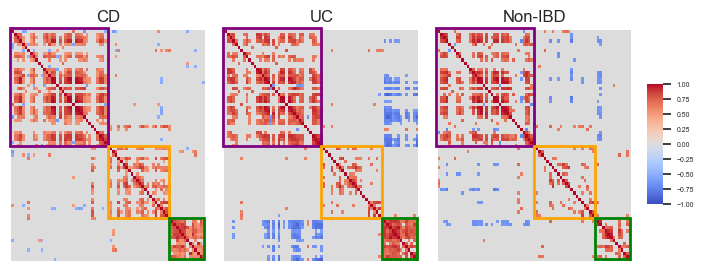

In [35]:
# Subset correlation matrices to metabolites of interest
pearson_corr_cd = pd.DataFrame(pearson_corr_cd, index=overlap_features, columns=overlap_features)
pearson_corr_uc = pd.DataFrame(pearson_corr_uc, index=overlap_features, columns=overlap_features)
pearson_corr_ctrl = pd.DataFrame(pearson_corr_ctrl, index=overlap_features, columns=overlap_features)
pearson_corr_cd_subset = pearson_corr_cd.loc[cluster_all, cluster_all]
pearson_corr_uc_subset = pearson_corr_uc.loc[cluster_all, cluster_all]
pearson_corr_ctrl_subset = pearson_corr_ctrl.loc[cluster_all, cluster_all]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.1})

# Create a shared color bar axis
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cbar_ax.tick_params(labelsize=5)

# Plot heatmaps and add rectangles for clusters
for ax, data, title in zip(axs, [pearson_corr_cd_subset, pearson_corr_uc_subset, pearson_corr_ctrl_subset], ['CD', 'UC', 'Non-IBD']):
    sns.heatmap(data, cmap='coolwarm', cbar=ax == axs[0], vmin=-1, vmax=1, ax=ax, cbar_ax=cbar_ax if ax == axs[0] else None)
    ax.set_title(title)

    # Add rectangles for each cluster
    cluster1_indices = [cluster_all.index(feat) for feat in cluster1]
    cluster2_indices = [cluster_all.index(feat) for feat in cluster2]
    cluster3_indices = [cluster_all.index(feat) for feat in cluster3]

    add_cluster_rectangles(ax, cluster1_indices, 'purple')
    add_cluster_rectangles(ax, cluster2_indices, 'orange')
    add_cluster_rectangles(ax, cluster3_indices, 'green')

    # Remove ticks and labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='x', bottom=False)
    ax.tick_params(axis='y', left=False)

plt.savefig('../results/figures/ext_ibd_pearson.pdf', bbox_inches='tight')
plt.show()

### Spearman's correlation

In [36]:
def calculate_spearman_correlation(data, threshold=0.005):
    d = data.shape[1]
    corr_matrix = np.zeros((d, d))
    p_matrix = np.zeros((d, d))
    
    # Compute correlations and p-values for each pair
    for i in range(d):
        for j in range(d):
            if i == j:
                corr_matrix[i, j] = 1.0  # Diagonal correlations are 1
                p_matrix[i, j] = 0.0    # Diagonal p-values are 0
            elif i < j:
                corr, p_value = stats.spearmanr(data.iloc[:, i], data.iloc[:, j])
                corr_matrix[i, j] = corr
                p_matrix[i, j] = p_value
                corr_matrix[j, i] = corr
                p_matrix[j, i] = p_value
    
    # Zero out correlations with p-values >= threshold
    corr_matrix[p_matrix >= threshold] = 0
    
    return corr_matrix

In [37]:
spearman_corr_cd = calculate_spearman_correlation(clr_cd)
spearman_corr_uc = calculate_spearman_correlation(clr_uc)
spearman_corr_ctrl = calculate_spearman_correlation(clr_ctrl)

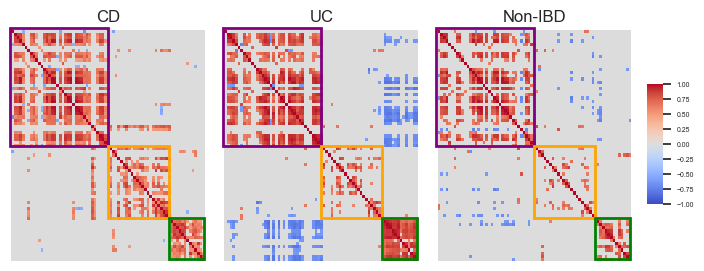

In [38]:
# Subset correlation matrices to metabolites of interest
spearman_corr_cd = pd.DataFrame(spearman_corr_cd, index=overlap_features, columns=overlap_features)
spearman_corr_uc = pd.DataFrame(spearman_corr_uc, index=overlap_features, columns=overlap_features)
spearman_corr_ctrl = pd.DataFrame(spearman_corr_ctrl, index=overlap_features, columns=overlap_features)
spearman_corr_cd_subset = spearman_corr_cd.loc[cluster_all, cluster_all]
spearman_corr_uc_subset = spearman_corr_uc.loc[cluster_all, cluster_all]
spearman_corr_ctrl_subset = spearman_corr_ctrl.loc[cluster_all, cluster_all]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={'width_ratios': [1, 1, 1], 'wspace': 0.1})

# Create a shared color bar axis
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
cbar_ax.tick_params(labelsize=5)

# Plot heatmaps and add rectangles for clusters
for ax, data, title in zip(axs, [spearman_corr_cd_subset, spearman_corr_uc_subset, spearman_corr_ctrl_subset], ['CD', 'UC', 'Non-IBD']):
    sns.heatmap(data, cmap='coolwarm', cbar=ax == axs[0], vmin=-1, vmax=1, ax=ax, cbar_ax=cbar_ax if ax == axs[0] else None)
    ax.set_title(title)

    # Add rectangles for each cluster
    cluster1_indices = [cluster_all.index(feat) for feat in cluster1]
    cluster2_indices = [cluster_all.index(feat) for feat in cluster2]
    cluster3_indices = [cluster_all.index(feat) for feat in cluster3]

    add_cluster_rectangles(ax, cluster1_indices, 'purple')
    add_cluster_rectangles(ax, cluster2_indices, 'orange')
    add_cluster_rectangles(ax, cluster3_indices, 'green')

    # Remove ticks and labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='x', bottom=False)
    ax.tick_params(axis='y', left=False)

plt.savefig('../results/figures/ext_ibd_spearman.pdf', bbox_inches='tight')
plt.show()

## Functional Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import requests
from bs4 import BeautifulSoup
from bioservices import KEGG
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

### Import data

In [2]:
file_path = '../results/intermediate_results/ibd/ibd_cluster_hmdb.csv'
df_cluster = pd.read_csv(file_path, index_col=0)
df_cluster.head()

,HMDB,Method
C8p_QI15,HMDB0011506,C8-pos
C8p_QI151,HMDB0005435,C8-pos
C8p_QI153,HMDB0005433,C8-pos
C8p_QI155,HMDB0005377,C8-pos
C8p_QI157,HMDB0005360,C8-pos


In [3]:
overlap_features = df_cluster.index.tolist()
start_idx = overlap_features.index("C8p_QI15")
end_idx = overlap_features.index("C8p_QI209") + 1  # Include the end element in the slice
cluster1 = overlap_features[start_idx:end_idx]

# Start and end indices for the second cluster
start_idx = overlap_features.index("C8p_QI21")
end_idx = overlap_features.index("C8p_QI43") + 1  # Include the end element in the slice
cluster2 = overlap_features[start_idx:end_idx]

# Start and end indices for the third cluster
start_idx = overlap_features.index("C8p_QI63")
end_idx = overlap_features.index("C8p_QI86") + 1  # Include the end element in the slice
cluster3 = overlap_features[start_idx:end_idx]

df_cluster1 = df_cluster.loc[cluster1, :]
df_cluster2 = df_cluster.loc[cluster2, :]
df_cluster3 = df_cluster.loc[cluster3, :]

### Retrieve chemical information

In [4]:
# Function to get the traditional name, SMILES, and InChI for a given HMDB ID with retry logic and error handling
def get_chemical_info(hmdb_id, retries=3, delay=5, timeout=10):
    # Check if the HMDB ID is missing
    if not isinstance(hmdb_id, str) or hmdb_id.strip() == "":
        return {
            'HMDB ID': np.nan,
            'Common Name': np.nan,
            'Traditional Name': np.nan,
            'SMILES': np.nan,
            'InChI Identifier': np.nan,
            'KEGG Compound ID': np.nan
        }
    
    url = f"http://www.hmdb.ca/metabolites/{hmdb_id}.xml"
    
    # Attempt the request with retry logic
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=timeout)  # Set a timeout of 10 seconds
            # Check if the request was successful
            if response.status_code == 200:
                # Parse the XML data using BeautifulSoup
                soup = BeautifulSoup(response.content, 'lxml')
                
                # Extract traditional name, SMILES, and InChI
                common_name = soup.find('name')
                traditional_name = soup.find('traditional_iupac')
                smiles = soup.find('smiles')
                inchi = soup.find('inchi')
                kegg_id = soup.find('kegg_id')
                
                # Return the values as a dictionary
                return {
                    'HMDB ID': hmdb_id,
                    'Common Name': common_name.text if common_name else None,
                    'Traditional Name': traditional_name.text if traditional_name else None,
                    'SMILES': smiles.text if smiles else None,
                    'InChI Identifier': inchi.text if inchi else None,
                    'KEGG Compound ID': kegg_id.text if kegg_id else None
                }
            else:
                print(f"Failed to retrieve data for {hmdb_id}. Status code: {response.status_code}")
        
        except requests.exceptions.Timeout:
            print(f"Request timed out for {hmdb_id}. Attempt {attempt + 1} of {retries}. Retrying in {delay} seconds...")
            time.sleep(delay)
        except requests.exceptions.RequestException as e:
            print(f"Request failed for {hmdb_id} due to an error: {e}. Attempt {attempt + 1} of {retries}. Retrying in {delay} seconds...")
            time.sleep(delay)

    print(f"Failed to retrieve data for {hmdb_id} after {retries} attempts.")
    return None

In [5]:
# # Example HMDB ID
# hmdb_id = "HMDB0010370"

# # Retrieve the XML data from HMDB
# url = f"http://www.hmdb.ca/metabolites/{hmdb_id}.xml"
# response = requests.get(url)

# # Print the XML content to inspect the structure
# print(response.text)

In [6]:
# hmdb_ids1 = df_cluster1['HMDB'].tolist()
# chemical_info_list1 = [get_chemical_info(hmdb_id, timeout=60) for hmdb_id in hmdb_ids1]
# df_chemical_info1 = pd.DataFrame(chemical_info_list1)

# hmdb_ids2 = df_cluster2['HMDB'].tolist()
# chemical_info_list2 = [get_chemical_info(hmdb_id, timeout=60) for hmdb_id in hmdb_ids2]
# df_chemical_info2 = pd.DataFrame(chemical_info_list2)

# hmdb_ids3 = df_cluster3['HMDB'].tolist()
# chemical_info_list3 = [get_chemical_info(hmdb_id, timeout=60) for hmdb_id in hmdb_ids3]
# df_chemical_info3 = pd.DataFrame(chemical_info_list3)

In [7]:
# df_merge1 = pd.merge(df_cluster1, df_chemical_info1, left_on="HMDB", right_on="HMDB ID", how="inner")
# df_merge2 = pd.merge(df_cluster2, df_chemical_info2, left_on="HMDB", right_on="HMDB ID", how="inner")
# df_merge3 = pd.merge(df_cluster3, df_chemical_info3, left_on="HMDB", right_on="HMDB ID", how="inner")

# output_file = '../results/outputs/ibd/ibd_metabolites_full_list.xlsx'
# with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
#     df_merge1.to_excel(writer, sheet_name='cluster1', index=False)
#     df_merge2.to_excel(writer, sheet_name='cluster2', index=False)
#     df_merge3.to_excel(writer, sheet_name='cluster3', index=False)

In [8]:
df_merge1 = pd.read_excel('../results/outputs/ibd/ibd_metabolites_full_list.xlsx', sheet_name='cluster1')
df_merge2 = pd.read_excel('../results/outputs/ibd/ibd_metabolites_full_list.xlsx', sheet_name='cluster2')
df_merge3 = pd.read_excel('../results/outputs/ibd/ibd_metabolites_full_list.xlsx', sheet_name='cluster3')

In [9]:
df_merge1.head()

,HMDB,Method,HMDB ID,Common Name,Traditional Name,SMILES,InChI Identifier,KEGG Compound ID
0,HMDB0011506,C8-pos,HMDB0011506,LysoPE(18:1(9Z)/0:0),2-aminoethoxy(2R)-2-hydroxy-3-[(9Z)-octadec-9-...,[H][C@@](O)(COC(=O)CCCCCCC\C=C/CCCCCCCC)COP(O)...,InChI=1S/C23H46NO7P/c1-2-3-4-5-6-7-8-9-10-11-1...,NaN
1,HMDB0005435,C8-pos,HMDB0005435,"TG(16:1(9Z)/16:1(9Z)/18:2(9Z,12Z))","(2S)-2,3-bis[(9Z)-hexadec-9-enoyloxy]propyl (9...",[H][C@](COC(=O)CCCCCCC\C=C/CCCCCC)(COC(=O)CCCC...,InChI=1S/C53H94O6/c1-4-7-10-13-16-19-22-25-26-...,C00422
2,HMDB0005433,C8-pos,HMDB0005433,TG(16:1(9Z)/16:1(9Z)/18:1(9Z)),"(2S)-2,3-bis[(9Z)-hexadec-9-enoyloxy]propyl (9...",[H][C@](COC(=O)CCCCCCC\C=C/CCCCCC)(COC(=O)CCCC...,InChI=1S/C53H96O6/c1-4-7-10-13-16-19-22-25-26-...,C00422
3,HMDB0005377,C8-pos,HMDB0005377,TG(16:0/16:1(9Z)/18:1(9Z)),(2S)-2-[(9Z)-hexadec-9-enoyloxy]-3-(hexadecano...,[H][C@](COC(=O)CCCCCCCCCCCCCCC)(COC(=O)CCCCCCC...,InChI=1S/C53H98O6/c1-4-7-10-13-16-19-22-25-26-...,C00422
4,HMDB0005360,C8-pos,HMDB0005360,TG(16:0_34:1),"(2S)-2,3-bis(hexadecanoyloxy)propyl (9Z)-octad...",[H][C@](COC(=O)CCCCCCCCCCCCCCC)(COC(=O)CCCCCCC...,InChI=1S/C53H100O6/c1-4-7-10-13-16-19-22-25-26...,C00422


### Compute Tanimoto similarities

In [10]:
df_merge = pd.concat([df_merge1, df_merge2, df_merge3], axis=0, ignore_index=True)

# Convert SMILES to RDKit Mol objects
df_merge['Mol'] = df_merge['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)

# Create a fingerprint generator
fpgen = AllChem.GetRDKitFPGenerator()

# Compute fingerprints for all molecules
df_merge['Fingerprint'] = df_merge['Mol'].apply(lambda x: fpgen.GetFingerprint(x) if x else None)

# Initialize an empty DataFrame for storing Tanimoto scores
tanimoto_df = pd.DataFrame(0.0, index=overlap_features, columns=overlap_features)

# Compute pairwise Tanimoto scores
for i in range(len(df_merge)):
    for j in range(i, len(df_merge)):  # Calculate only upper triangle, including diagonal
        fp1 = df_merge.iloc[i]['Fingerprint']
        fp2 = df_merge.iloc[j]['Fingerprint']
        if fp1 is not None and fp2 is not None:  
            tanimoto_score = DataStructs.TanimotoSimilarity(fp1, fp2)
        else:
            tanimoto_score = 0
        
        # Set the Tanimoto score in both (i, j) and (j, i) since the matrix is symmetric
        tanimoto_df.iloc[i, j] = tanimoto_score
        tanimoto_df.iloc[j, i] = tanimoto_score
tanimoto_df.to_csv('../results/outputs/ibd/ibd_tanimoto.csv')

In [11]:
# Extract the upper triangular part, excluding the diagonal
tanimoto_df1 = tanimoto_df.loc[cluster1, cluster1]
tanimoto_df2 = tanimoto_df.loc[cluster2, cluster2]
tanimoto_df3 = tanimoto_df.loc[cluster3, cluster3]

upper_tri_tanimoto1 = tanimoto_df1.where(np.triu(np.ones(tanimoto_df1.shape), k=1).astype(bool)).stack()
upper_tri_tanimoto2 = tanimoto_df2.where(np.triu(np.ones(tanimoto_df2.shape), k=1).astype(bool)).stack()
upper_tri_tanimoto3 = tanimoto_df3.where(np.triu(np.ones(tanimoto_df3.shape), k=1).astype(bool)).stack()

# Compute summary statistics
summary_tanimoto1 = upper_tri_tanimoto1.describe()
summary_tanimoto2 = upper_tri_tanimoto2.describe()
summary_tanimoto3 = upper_tri_tanimoto3.describe()

# Display results
print(summary_tanimoto1)
print(summary_tanimoto2)
print(summary_tanimoto3)

count    666.000000
mean       0.786617
std        0.242032
min        0.335938
25%        0.449036
50%        0.903766
75%        0.953975
max        1.000000
dtype: float64
count    253.000000
mean       0.761961
std        0.312925
min        0.000000
25%        0.815126
50%        0.850000
75%        0.967816
max        1.000000
dtype: float64
count    78.000000
mean      0.975696
std       0.019376
min       0.929978
25%       0.957798
50%       0.975169
75%       0.995485
max       1.000000
dtype: float64


In [12]:
# Function to add rectangles for clusters
def add_cluster_rectangles(ax, cluster_indices, color, linewidth=2):
    """Add rectangles to highlight clusters."""
    start = min(cluster_indices)
    end = max(cluster_indices) + 1  # Include the last index
    ax.add_patch(
        plt.Rectangle(
            (start - 0.5, start - 0.5),  # Bottom-left corner
            end - start,                # Width
            end - start,                # Height
            edgecolor=color,
            fill=False,
            lw=linewidth,
            clip_on=False
        )
    )

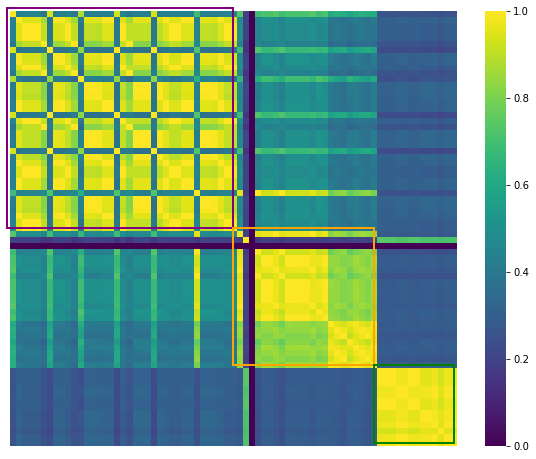

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(tanimoto_df, cmap='viridis', vmin=0, vmax=1, ax=ax)

# Add rectangles for each cluster
cluster1_indices = [overlap_features.index(feat) for feat in cluster1 if feat in overlap_features]
cluster2_indices = [overlap_features.index(feat) for feat in cluster2 if feat in overlap_features]
cluster3_indices = [overlap_features.index(feat) for feat in cluster3 if feat in overlap_features]

add_cluster_rectangles(ax, cluster1_indices, 'purple')
add_cluster_rectangles(ax, cluster2_indices, 'orange')
add_cluster_rectangles(ax, cluster3_indices, 'green')

# Remove ticks and labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='x', bottom=False)
ax.tick_params(axis='y', left=False)

plt.savefig('../results/figures/ext_ibd_tanimoto.pdf', bbox_inches='tight')
plt.show()

### Retrieve KEGG pathways

In [14]:
kegg_ids1 = df_merge1.dropna(subset=['KEGG Compound ID'])['KEGG Compound ID'].to_list()
kegg_ids2 = df_merge2.dropna(subset=['KEGG Compound ID'])['KEGG Compound ID'].to_list()
kegg_ids3 = df_merge2.dropna(subset=['KEGG Compound ID'])['KEGG Compound ID'].to_list()

In [15]:
# Initialize the KEGG service
kegg = KEGG()

# Function to get pathways for a given KEGG ID
def get_kegg_pathways(kegg_id):
    try:
        # Query KEGG database for the given KEGG ID
        entry = kegg.get(kegg_id)
        
        # Parse the entry and retrieve pathway information
        pathways = kegg.parse(entry).get("PATHWAY", {})
        return pathways
    except Exception as e:
        print(f"Error fetching pathways for {kegg_id}: {e}")
        return {}
    
# Function to get all KEGG compounds in a pathway (background)
def get_background_compounds(pathway_id, retries=3, timeout=10):
    # Define the KEGG REST API URL
    url = f"https://rest.kegg.jp/link/cpd/{pathway_id}"
    attempt = 0

    while attempt < retries:
        try:
            # Send a request to the KEGG REST API with a timeout of 10 seconds
            response = requests.get(url, timeout=timeout)

            # If the request was successful, process the response
            if response.status_code == 200:
                # Split the response by lines
                lines = response.text.strip().split("\n")

                # Extract the compound IDs (right column in each line) and remove the 'cpd:' prefix
                compounds = [line.split("\t")[1].replace("cpd:", "") for line in lines]

                return compounds

            else:
                print(f"Error: Received status code {response.status_code}. Retrying...")

        except requests.exceptions.RequestException as e:
            print(f"Error: {e}. Retrying...")

        # Increment the attempt counter and wait for a bit before retrying
        attempt += 1
        time.sleep(2)  # Sleep for 2 seconds before retrying

    # If all attempts failed, return an empty list
    print(f"Error: Failed to fetch data after {retries} attempts.")
    return []

# Function to calculate enrichment for a given pathway using Fisher's exact test
def calculate_enrichment(observed_compounds, background_compounds, total_compounds):
    observed_in_pathway = len(set(observed_compounds).intersection(set(background_compounds)))
    not_in_pathway = len(observed_compounds) - observed_in_pathway
    pathway_size = len(background_compounds)
    total_not_in_pathway = total_compounds - pathway_size

    # Create a contingency table
    contingency_table = [
        [observed_in_pathway, not_in_pathway],
        [pathway_size - observed_in_pathway, total_not_in_pathway - not_in_pathway]
    ]

    # Perform Fisher's exact test
    _, p_value = fisher_exact(contingency_table, alternative='greater')
    
    return p_value

In [16]:
# # List to store the results
# list_pathways1 = []
# list_pathways2 = []
# list_pathways3 = []

# # Retrieve pathways for each KEGG ID and collect the pathway ID and name
# for kegg_id in kegg_ids1:
#     pathways = get_kegg_pathways(kegg_id)
#     for pathway_id, pathway_name in pathways.items():
#         list_pathways1.append({
#             'KEGG_ID': kegg_id,
#             'Pathway_ID': pathway_id,
#             'Pathway_Name': pathway_name
#         })
# for kegg_id in kegg_ids2:
#     pathways = get_kegg_pathways(kegg_id)
#     for pathway_id, pathway_name in pathways.items():
#         list_pathways2.append({
#             'KEGG_ID': kegg_id,
#             'Pathway_ID': pathway_id,
#             'Pathway_Name': pathway_name
#         })
        
# for kegg_id in kegg_ids3:
#     pathways = get_kegg_pathways(kegg_id)
#     for pathway_id, pathway_name in pathways.items():
#         list_pathways3.append({
#             'KEGG_ID': kegg_id,
#             'Pathway_ID': pathway_id,
#             'Pathway_Name': pathway_name
#         })
        
# df_pathways1 = pd.DataFrame(list_pathways1)
# df_pathways2 = pd.DataFrame(list_pathways2)
# df_pathways3 = pd.DataFrame(list_pathways3)

# output_file = '../results/outputs/ibd/ibd_pathway.xlsx'
# with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
#     df_pathways1.to_excel(writer, sheet_name='cluster1', index=False)
#     df_pathways2.to_excel(writer, sheet_name='cluster2', index=False)
#     df_pathways3.to_excel(writer, sheet_name='cluster3', index=False)

In [17]:
df_pathways1 = pd.read_excel('../results/outputs/ibd/ibd_pathway.xlsx', sheet_name='cluster1')
df_pathways2 = pd.read_excel('../results/outputs/ibd/ibd_pathway.xlsx', sheet_name='cluster2')
df_pathways3 = pd.read_excel('../results/outputs/ibd/ibd_pathway.xlsx', sheet_name='cluster3')

In [18]:
df_pathways1['Pathway_Name'].value_counts()

Pathway_Name
Glycerolipid metabolism                  23
Metabolic pathways                       23
Thermogenesis                            23
Regulation of lipolysis in adipocytes    23
Insulin resistance                       23
Fat digestion and absorption             23
Vitamin digestion and absorption         23
Cholesterol metabolism                   23
Lipid and atherosclerosis                23
Name: count, dtype: int64

In [19]:
df_pathways2['Pathway_Name'].value_counts()

Pathway_Name
Metabolic pathways                                                 2
Steroid biosynthesis                                               1
Bile secretion                                                     1
Folate transport and metabolism                                    1
Retrograde endocannabinoid signaling                               1
Biosynthesis of secondary metabolites                              1
alpha-Linolenic acid metabolism                                    1
Linoleic acid metabolism                                           1
Arachidonic acid metabolism                                        1
Glycerophospholipid metabolism                                     1
Lipid and atherosclerosis                                          1
Basal cell carcinoma                                               1
Pathways in cancer                                                 1
Cholesterol metabolism                                             1
Vitamin digestion and

In [20]:
df_pathways3['Pathway_Name'].value_counts()

Pathway_Name
Metabolic pathways                                                 2
Steroid biosynthesis                                               1
Bile secretion                                                     1
Folate transport and metabolism                                    1
Retrograde endocannabinoid signaling                               1
Biosynthesis of secondary metabolites                              1
alpha-Linolenic acid metabolism                                    1
Linoleic acid metabolism                                           1
Arachidonic acid metabolism                                        1
Glycerophospholipid metabolism                                     1
Lipid and atherosclerosis                                          1
Basal cell carcinoma                                               1
Pathways in cancer                                                 1
Cholesterol metabolism                                             1
Vitamin digestion and

### Pathway enrichment analysis

In [21]:
# # Get the list of all KEGG compounds
# compound_list = kegg.list("compound")

# # Split the list into lines and count them
# total_kegg_compounds = len(compound_list.strip().split("\n"))

# print(f"Total number of KEGG compounds: {total_kegg_compounds}")

In [22]:
# # List to store results
# enr_results1 = []

# # Loop through each unique pathway among metabolites in cluster 1
# for pathway_id in df_pathways1['Pathway_ID'].unique():
#     # Get the observed KEGG compounds in the pathway
#     observed_compounds = df_pathways1[df_pathways1['Pathway_ID'] == pathway_id]['KEGG_ID'].tolist()

#     # Get the background KEGG compounds for the pathway from KEGG database
#     background_compounds = get_background_compounds(pathway_id)

#     # Calculate enrichment p-value
#     p_value = calculate_enrichment(observed_compounds, background_compounds, total_kegg_compounds)
    
#     # Get pathway name
#     pathway_name = df_pathways1[df_pathways1['Pathway_ID'] == pathway_id]['Pathway_Name'].iloc[0]

#     # Store the result
#     enr_results1.append({
#         'Pathway_ID': pathway_id,
#         'Pathway_Name': pathway_name,
#         'P-value': p_value
#     })

# # Convert the results into a DataFrame
# df_enr1 = pd.DataFrame(enr_results1)
# # Adjust the p-values
# _, adjusted_p_values, _, _ = multipletests(df_enr1['P-value'].values, method='holm')
# df_enr1['Adjusted P-value'] = adjusted_p_values

In [23]:
# # List to store results
# enr_results2 = []

# # Loop through each unique pathway among metabolites in cluster 2
# for pathway_id in df_pathways2['Pathway_ID'].unique():
#     # Get the observed KEGG compounds in the pathway
#     observed_compounds = df_pathways2[df_pathways2['Pathway_ID'] == pathway_id]['KEGG_ID'].tolist()

#     # Get the background KEGG compounds for the pathway from KEGG database
#     background_compounds = get_background_compounds(pathway_id)

#     # Calculate enrichment p-value
#     p_value = calculate_enrichment(observed_compounds, background_compounds, total_kegg_compounds)
    
#     # Get pathway name
#     pathway_name = df_pathways2[df_pathways2['Pathway_ID'] == pathway_id]['Pathway_Name'].iloc[0]

#     # Store the result
#     enr_results2.append({
#         'Pathway_ID': pathway_id,
#         'Pathway_Name': pathway_name,
#         'P-value': p_value
#     })

# # Convert the results into a DataFrame
# df_enr2 = pd.DataFrame(enr_results2)
# # Adjust the p-values
# _, adjusted_p_values, _, _ = multipletests(df_enr2['P-value'].values, method='holm')
# df_enr2['Adjusted P-value'] = adjusted_p_values

In [24]:
# # List to store results
# enr_results3 = []

# # Loop through each unique pathway among metabolites in cluster 2
# for pathway_id in df_pathways3['Pathway_ID'].unique():
#     # Get the observed KEGG compounds in the pathway
#     observed_compounds = df_pathways3[df_pathways3['Pathway_ID'] == pathway_id]['KEGG_ID'].tolist()

#     # Get the background KEGG compounds for the pathway from KEGG database
#     background_compounds = get_background_compounds(pathway_id)

#     # Calculate enrichment p-value
#     p_value = calculate_enrichment(observed_compounds, background_compounds, total_kegg_compounds)
    
#     # Get pathway name
#     pathway_name = df_pathways3[df_pathways3['Pathway_ID'] == pathway_id]['Pathway_Name'].iloc[0]

#     # Store the result
#     enr_results3.append({
#         'Pathway_ID': pathway_id,
#         'Pathway_Name': pathway_name,
#         'P-value': p_value
#     })

# # Convert the results into a DataFrame
# df_enr3 = pd.DataFrame(enr_results3)
# # Adjust the p-values
# _, adjusted_p_values, _, _ = multipletests(df_enr3['P-value'].values, method='holm')
# df_enr3['Adjusted P-value'] = adjusted_p_values

In [25]:
# df_enr1.sort_values(by='P-value', ascending=True, inplace=True, ignore_index=True)
# df_enr2.sort_values(by='P-value', ascending=True, inplace=True, ignore_index=True)
# df_enr3.sort_values(by='P-value', ascending=True, inplace=True, ignore_index=True)

# output_file = '../results/outputs/ibd/ibd_enrichment.xlsx'
# with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
#     df_enr1.to_excel(writer, sheet_name='cluster1', index=False)
#     df_enr2.to_excel(writer, sheet_name='cluster2', index=False)
#     df_enr3.to_excel(writer, sheet_name='cluster3', index=False)

In [26]:
df_enr1 = pd.read_excel('../results/outputs/ibd/ibd_enrichment.xlsx', sheet_name='cluster1')
df_enr2 = pd.read_excel('../results/outputs/ibd/ibd_enrichment.xlsx', sheet_name='cluster2')
df_enr3 = pd.read_excel('../results/outputs/ibd/ibd_enrichment.xlsx', sheet_name='cluster3')

In [27]:
df_enr1

,Pathway_ID,Pathway_Name,P-value,Adjusted P-value
0,map04979,Cholesterol metabolism,0.011790,0.106109
1,map04975,Fat digestion and absorption,0.015301,0.122407
2,map04923,Regulation of lipolysis in adipocytes,0.016469,0.122407
3,map05417,Lipid and atherosclerosis,0.016469,0.122407
4,map04931,Insulin resistance,0.022287,0.122407
5,map04714,Thermogenesis,0.026918,0.122407
6,map00561,Glycerolipid metabolism,0.044098,0.132295
7,map04977,Vitamin digestion and absorption,0.048631,0.132295
8,map01100,Metabolic pathways,0.982580,0.982580


In [28]:
df_enr2

,Pathway_ID,Pathway_Name,P-value,Adjusted P-value
0,map05217,Basal cell carcinoma,0.000052,0.001494
1,map04979,Cholesterol metabolism,0.000515,0.014426
2,map05231,Choline metabolism in cancer,0.000567,0.015302
3,map04927,Cortisol synthesis and secretion,0.000618,0.016075
4,map04934,Cushing syndrome,0.000670,0.016745
5,map04975,Fat digestion and absorption,0.000670,0.016745
6,map05417,Lipid and atherosclerosis,0.000721,0.016745
7,map00984,Steroid degradation,0.000927,0.020403
8,map04723,Retrograde endocannabinoid signaling,0.000979,0.020557
9,map04981,Folate transport and metabolism,0.001030,0.020609


In [29]:
df_enr3

,Pathway_ID,Pathway_Name,P-value,Adjusted P-value
0,map05217,Basal cell carcinoma,0.000052,0.001494
1,map04979,Cholesterol metabolism,0.000515,0.014426
2,map05231,Choline metabolism in cancer,0.000567,0.015302
3,map04927,Cortisol synthesis and secretion,0.000618,0.016075
4,map04934,Cushing syndrome,0.000670,0.016745
5,map04975,Fat digestion and absorption,0.000670,0.016745
6,map05417,Lipid and atherosclerosis,0.000721,0.016745
7,map00984,Steroid degradation,0.000927,0.020403
8,map04723,Retrograde endocannabinoid signaling,0.000979,0.020557
9,map04981,Folate transport and metabolism,0.001030,0.020609
